# Pipeline for Test Datasets (Using **Perplexity** as Metric)

#### Import Libraries

In [1]:
import json
import torch
from transformers import GPT2Tokenizer, GPT2Model
import evaluate
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

d:\anaconda3\envs\clean_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the testing dataset

In [2]:
# Load the dataset from a JSON file
def load_dataset(filepath):
    with open(filepath, "r") as f:
        return json.load(f)

dataset_path = "Dekeyser_test_dataset.json"
dataset = load_dataset(dataset_path)

# Display the first few items to verify loading
dataset[:2]

[{'pair_id': 1,
  'rule_type': 'past_tense',
  'sub_rule_type': 'past_tense_marking_omitted_in_obligatory_context (PTMO)',
  'sentences': [{'text': 'Last night the old lady die in her sleep.',
    'is_grammatical': False},
   {'text': 'Last night the old lady died in her sleep.',
    'is_grammatical': True}]},
 {'pair_id': 2,
  'rule_type': 'past_tense',
  'sub_rule_type': 'past_tense_marking_omitted_in_obligatory_context (PTMO)',
  'sentences': [{'text': 'Sandy fill a jar with cookies last night.',
    'is_grammatical': False},
   {'text': 'Sandy filled a jar with cookies last night.',
    'is_grammatical': True}]}]

### Load GPT-2 Model and Tokenizer

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")
model.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

### Perplexity Calculation

In [4]:
# Load the perplexity metric from Hugging Face's evaluate library
perplexity_metric = evaluate.load("perplexity", module_type="metric")

# Function to calculate perplexity using Hugging Face's evaluate library
def calculate_perplexity(sentence):
    results = perplexity_metric.compute(model_id="gpt2", predictions=[sentence], add_start_token=False)
    return results["perplexities"][0]

# Results storage
results_with_perplexity = []
all_perplexities = []

In [5]:
# Step 1: Calculate perplexities for all sentences
for item in dataset:
    pair_id = item["pair_id"]
    grammatical_sentence = item["sentences"][1]["text"]
    ungrammatical_sentence = item["sentences"][0]["text"]

    # Compute perplexities
    grammatical_perplexity = calculate_perplexity(grammatical_sentence)
    ungrammatical_perplexity = calculate_perplexity(ungrammatical_sentence)

    # Store raw perplexities
    all_perplexities.extend([grammatical_perplexity, ungrammatical_perplexity])

    # Append results
    results_with_perplexity.append({
        "Pair ID": pair_id,
        "Grammatical Sentence": grammatical_sentence,
        "Grammatical Perplexity": grammatical_perplexity,
        "Ungrammatical Sentence": ungrammatical_sentence,
        "Ungrammatical Perplexity": ungrammatical_perplexity,
        "Grammatical Length": len(tokenizer.tokenize(grammatical_sentence)),
        "Ungrammatical Length": len(tokenizer.tokenize(ungrammatical_sentence))
    })

100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


In [6]:
# Function to get token count
def get_token_length(tokenizer, sentence):
    input_ids = tokenizer.encode(sentence, return_tensors="pt")
    return len(input_ids[0])  # Number of tokens in the encoded input

In [7]:
# Normalize perplexities and store in results_with_perplexity
min_perplexity = min(all_perplexities)
max_perplexity = max(all_perplexities)

for result in results_with_perplexity:
    result["Grammatical Length"] = get_token_length(tokenizer, result["Grammatical Sentence"])
    result["Ungrammatical Length"] = get_token_length(tokenizer, result["Ungrammatical Sentence"])

    # Min-Max Normalization
    result["Grammatical Perplexity (Min-Max Normalized)"] = (
        (result["Grammatical Perplexity"] - min_perplexity) / (max_perplexity - min_perplexity)
    )
    result["Ungrammatical Perplexity (Min-Max Normalized)"] = (
        (result["Ungrammatical Perplexity"] - min_perplexity) / (max_perplexity - min_perplexity)
    )
    
    # Compute length-normalized perplexity
    result["Grammatical Perplexity (Length-Normalized)"] = (
        result["Grammatical Perplexity"] / result["Grammatical Length"]
    )
    result["Ungrammatical Perplexity (Length-Normalized)"] = (
        result["Ungrammatical Perplexity"] / result["Ungrammatical Length"]
    )

# Convert to a DataFrame for analysis
results_df = pd.DataFrame(results_with_perplexity)

In [8]:
# Add tokenized versions of grammatical and ungrammatical sentences
for result in results_with_perplexity:
    # Tokenize sentences
    result["Grammatical Tokens"] = tokenizer.tokenize(result["Grammatical Sentence"])
    result["Ungrammatical Tokens"] = tokenizer.tokenize(result["Ungrammatical Sentence"])

# Convert to a DataFrame for analysis, including tokenized columns
results_df = pd.DataFrame(results_with_perplexity)

# Adjust Pandas display settings to show the entire DataFrame
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Display the updated DataFrame
display(results_df)

,Pair ID,Grammatical Sentence,Grammatical Perplexity,Ungrammatical Sentence,Ungrammatical Perplexity,Grammatical Length,Ungrammatical Length,Grammatical Perplexity (Min-Max Normalized),Ungrammatical Perplexity (Min-Max Normalized),Grammatical Perplexity (Length-Normalized),Ungrammatical Perplexity (Length-Normalized),Grammatical Tokens,Ungrammatical Tokens
0,1,Last night the old lady died in her sleep.,38.770782,Last night the old lady die in her sleep.,98.972351,10,10,0.003198,0.013331,3.877078,9.897235,"[Last, Ġnight, Ġthe, Ġold, Ġlady, Ġdied, Ġin, Ġher, Ġsleep, .]","[Last, Ġnight, Ġthe, Ġold, Ġlady, Ġdie, Ġin, Ġher, Ġsleep, .]"
1,2,Sandy filled a jar with cookies last night.,240.426910,Sandy fill a jar with cookies last night.,478.716583,10,10,0.037140,0.077248,24.042691,47.871658,"[S, andy, Ġfilled, Ġa, Ġjar, Ġwith, Ġcookies, Ġlast, Ġnight, .]","[S, andy, Ġfill, Ġa, Ġjar, Ġwith, Ġcookies, Ġlast, Ġnight, .]"
2,3,John sang for the church choir yesterday.,283.214478,John sing for the church choir yesterday.,287.995056,8,8,0.044342,0.045147,35.401810,35.999382,"[John, Ġsang, Ġfor, Ġthe, Ġchurch, Ġchoir, Ġyesterday, .]","[John, Ġsing, Ġfor, Ġthe, Ġchurch, Ġchoir, Ġyesterday, .]"
3,4,Janie slept with her teddy bear last night.,47.478760,Janie sleeped with her teddy bear last night.,69.498711,11,12,0.004664,0.008370,4.316251,5.791559,"[Jan, ie, Ġslept, Ġwith, Ġher, Ġt, eddy, Ġbear, Ġlast, Ġnight, .]","[Jan, ie, Ġsleep, ed, Ġwith, Ġher, Ġt, eddy, Ġbear, Ġlast, Ġnight, .]"
4,5,Last night the books fell off the shelves.,56.160061,Last night the books falled off the shelves.,145.991745,9,10,0.006125,0.021245,6.240007,14.599174,"[Last, Ġnight, Ġthe, Ġbooks, Ġfell, Ġoff, Ġthe, Ġshelves, .]","[Last, Ġnight, Ġthe, Ġbooks, Ġfall, ed, Ġoff, Ġthe, Ġshelves, .]"
5,6,A policeman gave Alan a ticket for speeding yesterday.,317.011597,A policeman gived Alan a ticket for speeding yesterday.,778.446655,10,11,0.050031,0.127697,31.701160,70.767878,"[A, Ġpoliceman, Ġgave, ĠAlan, Ġa, Ġticket, Ġfor, Ġspeeding, Ġyesterday, .]","[A, Ġpoliceman, Ġg, ived, ĠAlan, Ġa, Ġticket, Ġfor, Ġspeeding, Ġyesterday, .]"
6,7,A bat flew into our attic last night.,210.209259,A bat flewed into our attic last night.,436.631531,9,10,0.032054,0.070164,23.356584,43.663153,"[A, Ġbat, Ġflew, Ġinto, Ġour, Ġattic, Ġlast, Ġnight, .]","[A, Ġbat, Ġflew, ed, Ġinto, Ġour, Ġattic, Ġlast, Ġnight, .]"
7,8,Yesterday the teacher sent Allison to the principal.,144.736740,Yesterday the teacher sented Allison to the principal.,230.520996,9,10,0.021034,0.035473,16.081860,23.052100,"[Yesterday, Ġthe, Ġteacher, Ġsent, ĠAllison, Ġto, Ġthe, Ġprincipal, .]","[Yesterday, Ġthe, Ġteacher, Ġsent, ed, ĠAllison, Ġto, Ġthe, Ġprincipal, .]"
8,9,Mr. Murphy hid his money under his mattress.,68.493896,Mr. Murphy hidded his money under his mattress.,255.408401,10,12,0.008201,0.039662,6.849390,21.284033,"[Mr, ., ĠMurphy, Ġhid, Ġhis, Ġmoney, Ġunder, Ġhis, Ġmattress, .]","[Mr, ., ĠMurphy, Ġh, idd, ed, Ġhis, Ġmoney, Ġunder, Ġhis, Ġmattress, .]"
9,10,Three boys played on the swings in the park.,43.403881,Three boy played on the swings in the park.,64.872719,10,10,0.003978,0.007592,4.340388,6.487272,"[Three, Ġboys, Ġplayed, Ġon, Ġthe, Ġswings, Ġin, Ġthe, Ġpark, .]","[Three, Ġboy, Ġplayed, Ġon, Ġthe, Ġswings, Ġin, Ġthe, Ġpark, .]"


In [9]:
# Filter for pairs where the grammatical perplexity is unexpectedly higher or equal
unexpected_cases = results_df[
    results_df["Grammatical Perplexity"] >= results_df["Ungrammatical Perplexity"]
]

# Count the number of unexpected cases
num_violations = len(unexpected_cases)
print(f"Number of unexpected cases: {num_violations}")

# Display the filtered DataFrame with tokenized sentences and their lengths
display(
    unexpected_cases[[
        "Pair ID",
        "Grammatical Sentence",
        "Grammatical Tokens",
        "Grammatical Length",
        "Grammatical Perplexity",
        "Ungrammatical Sentence",
        "Ungrammatical Tokens",
        "Ungrammatical Length",
        "Ungrammatical Perplexity"
    ]]
)

Number of unexpected cases: 7


,Pair ID,Grammatical Sentence,Grammatical Tokens,Grammatical Length,Grammatical Perplexity,Ungrammatical Sentence,Ungrammatical Tokens,Ungrammatical Length,Ungrammatical Perplexity
12,13,A shoe salesman sees many feet throughout the day.,"[A, Ġshoe, Ġsalesman, Ġsees, Ġmany, Ġfeet, Ġthroughout, Ġthe, Ġday, .]",10,459.831390,A shoe salesman sees many foots throughout the day.,"[A, Ġshoe, Ġsalesman, Ġsees, Ġmany, Ġfoot, s, Ġthroughout, Ġthe, Ġday, .]",11,442.024292
13,14,Two mice ran into the house this morning.,"[Two, Ġmice, Ġran, Ġinto, Ġthe, Ġhouse, Ġthis, Ġmorning, .]",9,137.050446,Two mouses ran into the house this morning.,"[Two, Ġm, ouses, Ġran, Ġinto, Ġthe, Ġhouse, Ġthis, Ġmorning, .]",10,72.157967
38,39,The men played basketball in the backyard.,"[The, Ġmen, Ġplayed, Ġbasketball, Ġin, Ġthe, Ġbackyard, .]",8,96.662277,The men played the basketball in the backyard.,"[The, Ġmen, Ġplayed, Ġthe, Ġbasketball, Ġin, Ġthe, Ġbackyard, .]",9,85.921249
77,78,What is Martha bringing to the party?,"[What, Ġis, ĠMartha, Ġbringing, Ġto, Ġthe, Ġparty, ?]",8,165.503464,What Martha is bringing to the party?,"[What, ĠMartha, Ġis, Ġbringing, Ġto, Ġthe, Ġparty, ?]",8,90.290283
89,90,The dog bites.,"[The, Ġdog, Ġbites, .]",4,748.962585,Bites the dog.,"[B, ites, Ġthe, Ġdog, .]",5,527.833374
90,91,The man drinks.,"[The, Ġman, Ġdrinks, .]",4,1446.507690,Drinks the man.,"[Dr, inks, Ġthe, Ġman, .]",5,372.528076
91,92,The woman paints.,"[The, Ġwoman, Ġpaints, .]",4,5960.986328,Paints the woman.,"[P, aints, Ġthe, Ġwoman, .]",5,999.679260


In [21]:
# Inspect tokenization
sentence1 = "The dog bites."
sentence2 = "Bites the dog."

tokens1 = tokenizer.tokenize(sentence1)
tokens2 = tokenizer.tokenize(sentence2)

print(f"Sentence 1: {sentence1}")
print(f"Tokens 1: {tokens1}")
print(f"Token Count 1: {len(tokens1)}")

print(f"Sentence 2: {sentence2}")
print(f"Tokens 2: {tokens2}")
print(f"Token Count 2: {len(tokens2)}")

Sentence 1: The dog bites.
Tokens 1: ['The', 'Ġdog', 'Ġbites', '.']
Token Count 1: 4
Sentence 2: Bites the dog.
Tokens 2: ['B', 'ites', 'Ġthe', 'Ġdog', '.']
Token Count 2: 5


## Visualizations

In [5]:
# Calculate perplexity for each sentence in the dataset
for item in dataset:
    pair_id = item["pair_id"]
    grammatical_sentence = item["sentences"][1]["text"]
    ungrammatical_sentence = item["sentences"][0]["text"]

    # Compute perplexities
    grammatical_perplexity = calculate_perplexity(grammatical_sentence)
    ungrammatical_perplexity = calculate_perplexity(ungrammatical_sentence)

    # Append results
    results_with_perplexity.append({
        "Pair ID": pair_id,
        "Grammatical Sentence": grammatical_sentence,
        "Grammatical Perplexity": grammatical_perplexity,
        "Ungrammatical Sentence": ungrammatical_sentence,
        "Ungrammatical Perplexity": ungrammatical_perplexity,
        "Matches Expectation": grammatical_perplexity < ungrammatical_perplexity
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results_with_perplexity)

# Display the first few rows
display(results_df)

100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


,Pair ID,Grammatical Sentence,Grammatical Perplexity,Ungrammatical Sentence,Ungrammatical Perplexity,Matches Expectation
0,1,Last night the old lady died in her sleep.,38.770782,Last night the old lady die in her sleep.,98.972351,True
1,2,Sandy filled a jar with cookies last night.,240.426910,Sandy fill a jar with cookies last night.,478.716583,True
2,3,John sang for the church choir yesterday.,283.214478,John sing for the church choir yesterday.,287.995056,True
3,4,Janie slept with her teddy bear last night.,47.478760,Janie sleeped with her teddy bear last night.,69.498711,True
4,5,Last night the books fell off the shelves.,56.160061,Last night the books falled off the shelves.,145.991745,True
...,...,...,...,...,...,...
93,94,The children play with the dog.,55.554737,The children with the dog play.,335.976074,True
94,95,All our friends live in the suburbs.,33.647957,All our friends in the suburbs live.,157.321716,True
95,96,The student eats his meals quickly.,235.814423,The student eats quickly his meals.,908.233948,True
96,97,Kevin usually rides his bicycle to work.,54.435120,Kevin rides usually his bicycle to work.,219.706177,True


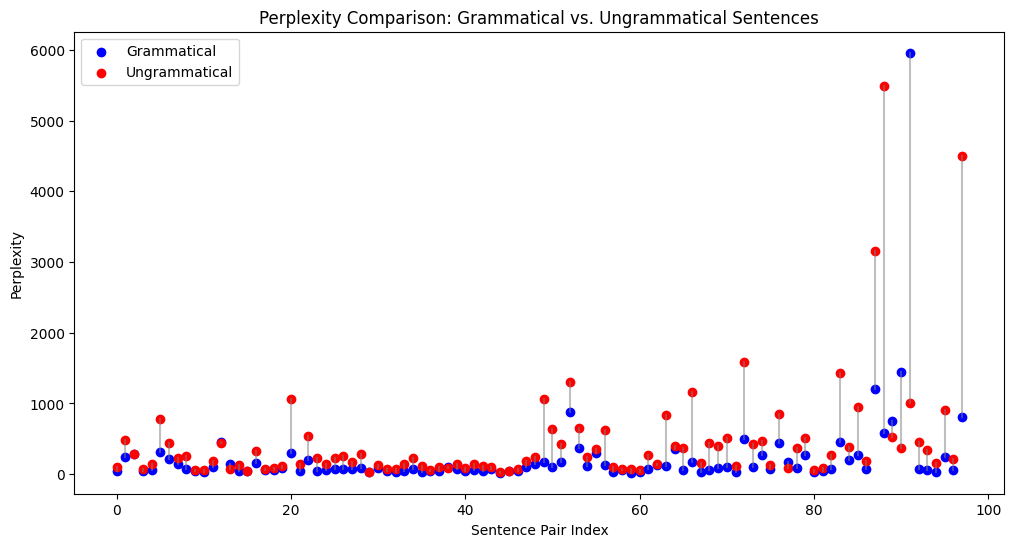

In [6]:
# Plot perplexities
plt.figure(figsize=(12, 6))
for idx, row in results_df.iterrows():
    plt.plot(
        [idx, idx],
        [row["Grammatical Perplexity"], row["Ungrammatical Perplexity"]],
        color="gray", alpha=0.5
    )
    plt.scatter(idx, row["Grammatical Perplexity"], label="Grammatical" if idx == 0 else "", color="blue")
    plt.scatter(idx, row["Ungrammatical Perplexity"], label="Ungrammatical" if idx == 0 else "", color="red")

plt.xlabel("Sentence Pair Index")
plt.ylabel("Perplexity")
plt.title("Perplexity Comparison: Grammatical vs. Ungrammatical Sentences")
plt.legend()
plt.show()

C:\Users\lazyl\AppData\Local\Temp\ipykernel_15432\2415192745.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grammatical, ungrammatical], labels=["Grammatical", "Ungrammatical"])


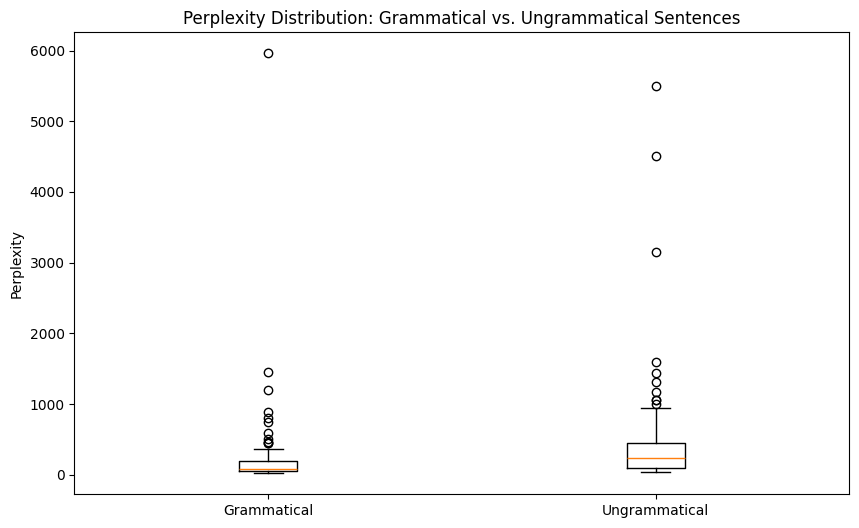

In [ ]:
# Visualize perplexity distribution for grammatical and ungrammatical sentences
def visualize_results(results):
    grammatical = [r["perplexity"] for r in results if r["is_grammatical"]]
    ungrammatical = [r["perplexity"] for r in results if not r["is_grammatical"]]

    plt.figure(figsize=(10, 6))
    plt.boxplot([grammatical, ungrammatical], labels=["Grammatical", "Ungrammatical"])
    plt.ylabel("Perplexity")
    plt.title("Perplexity Distribution: Grammatical vs. Ungrammatical Sentences")
    plt.show()

# Call the visualization function
visualize_results(results)

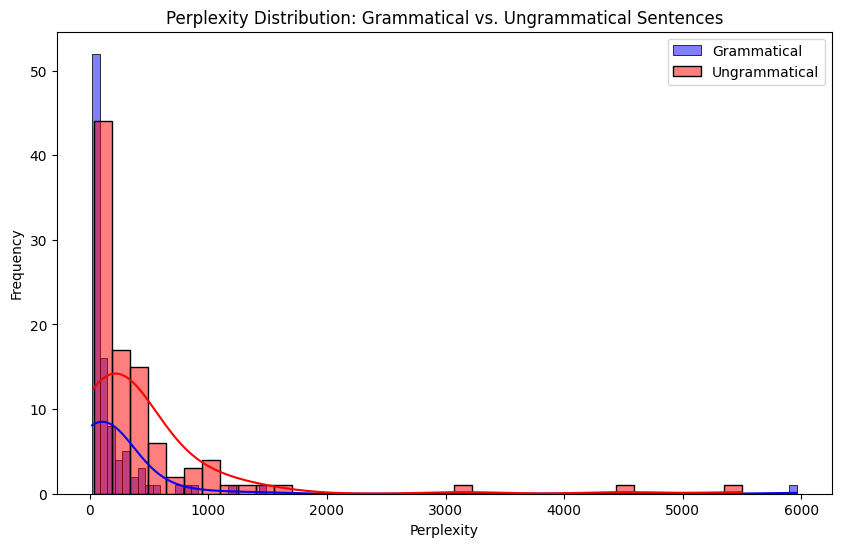

In [ ]:
import seaborn as sns

grammatical = [r["perplexity"] for r in results if r["is_grammatical"]]
ungrammatical = [r["perplexity"] for r in results if not r["is_grammatical"]]

plt.figure(figsize=(10, 6))
sns.histplot(grammatical, color="blue", kde=True, label="Grammatical")
sns.histplot(ungrammatical, color="red", kde=True, label="Ungrammatical")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.title("Perplexity Distribution: Grammatical vs. Ungrammatical Sentences")
plt.legend()
plt.show()

#### Deeper Token Analysis

torch.Size([1, 4, 50257])
tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3759,
           -34.9193],
         [-115.3818, -113.8694, -120.9712,  ..., -122.1812, -114.6535,
          -115.6624],
         [ -96.9043,  -98.0809, -102.0104,  ..., -104.3819, -102.0781,
          -100.1783],
         [-101.4069,  -98.9640, -101.4758,  ..., -110.9621, -108.5508,
           -94.1808]]])
8.6930513381958
Sentence: The woman paints.
Overall Perplexity: 5961.34
     Token  Log Probability  Loss (-Log Probability)
0      The        -7.708842                 7.708842
1   Ġwoman       -10.308980                10.308980
2  Ġpaints       -10.585052                10.585052
3        .       -10.758391                10.758391


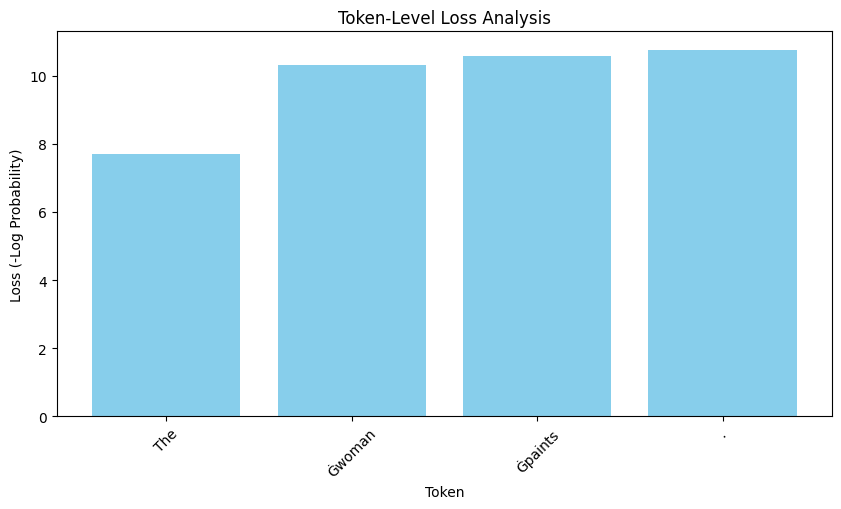

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import matplotlib.pyplot as plt

# Load GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

# Function to perform token-level analysis
def token_level_analysis(sentence):
    # Tokenize the sentence
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs["input_ids"]
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        logits = outputs.logits  # Model predictions
        loss = outputs.loss.item()  # Average loss for the sentence

        print(logits.shape)
        print(logits)
        print(loss)

    # Convert logits to probabilities
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # Get the token-level log probabilities for the correct tokens
    token_log_probs = []
    for idx, token_id in enumerate(input_ids[0]):
        token_log_prob = log_probs[0, idx, token_id].item()
        token_log_probs.append(token_log_prob)

    # Compute token-level losses (-log_probs)
    token_losses = [-log_prob for log_prob in token_log_probs]

    # Decode tokens for display
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Create a DataFrame for easier analysis
    token_analysis_df = pd.DataFrame({
        "Token": tokens,
        "Log Probability": token_log_probs,
        "Loss (-Log Probability)": token_losses
    })

    return token_analysis_df, loss

# Example: Analyze a sentence
sentence = "The woman paints."
token_analysis_df, sentence_loss = token_level_analysis(sentence)

# Display token-level analysis
print(f"Sentence: {sentence}")
print(f"Overall Perplexity: {torch.exp(torch.tensor(sentence_loss)).item():.2f}")
print(token_analysis_df)

# Plot token-level losses
plt.figure(figsize=(10, 5))
plt.bar(token_analysis_df["Token"], token_analysis_df["Loss (-Log Probability)"], color="skyblue")
plt.xlabel("Token")
plt.ylabel("Loss (-Log Probability)")
plt.title("Token-Level Loss Analysis")
plt.xticks(rotation=45)
plt.show()